## Generative AI for predictive breeding
### Code initially generated with ChatGPT, manually tested and polished
#### Simulate microbiome data using a log - normal distribution and generates synthetic data using VAE, GAN, ARR, diffusion and flow methods.


In [3]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [19]:
# ensures / or not reproducibility
seed = 42
np.random.seed(seed)

## Data simulation

In [20]:

def simulate_microbiome_data(num_samples=10, num_species=50):
    """
    Simulates microbiome abundance data using a log-normal distribution.
    
    Parameters:
    - num_samples: Number of samples
    - num_species: Number of microbial species
    - seed: Random seed for reproducibility (cancelled)
    
    Returns:
    - DataFrame with simulated microbial abundances.
    """
    
    # Generate log-normal distributed abundances for each species across samples
    mean_abundance = np.random.uniform(-3, 3, num_species)  # Mean log-abundance per species
    std_dev = np.random.uniform(0.5, 1.5, num_species)      # Variability per species
    
    abundance_matrix = np.array([
        np.random.lognormal(mean_abundance, std_dev) for _ in range(num_samples)
    ])
    
    # Normalize each sample to sum to a fixed number (e.g., 10,000 reads per sample)
    total_reads = 20000
    abundance_matrix = (abundance_matrix.T / abundance_matrix.sum(axis=1) * total_reads).T
    
    # Convert to DataFrame
    species = [f"Species_{i+1}" for i in range(num_species)]
    samples = [f"Sample_{i+1}" for i in range(num_samples)]
    df = pd.DataFrame(abundance_matrix, index=samples, columns=species)
    
    return df


In [21]:
def plot_microbiome_data(df, main='Simulated Microbiome Data'):
    """
    Plots the microbiome abundance data as histogram.
    
    Parameters:
    - df: DataFrame containing microbiome abundance data.
    """
    plt.hist(df.mean(axis=0), color='cyan', edgecolor='black', alpha=0.7)
    plt.ylabel('Count of Species')
    plt.xlabel('Species Mean Abundance')
    plt.title(main)
    plt.show()

           Species_1   Species_2   Species_3  Species_4   Species_5  \
Sample_1   16.511139  283.523483  585.876577   4.619761   17.996656   
Sample_2  133.831449  783.599445   20.233493   3.350984   69.905552   
Sample_3   24.524981  259.446200  243.678259  14.289582  116.117210   
Sample_4    5.290558  248.826455  113.632127   1.406439   56.079910   
Sample_5   23.369971  229.804888  399.849885   7.858757   73.019061   

           Species_6  Species_7    Species_8   Species_9   Species_10  ...  \
Sample_1    4.344675   7.637186   162.328484  169.590807   408.067963  ...   
Sample_2    6.560713  13.269081  9628.184291   30.438467   469.800854  ...   
Sample_3   18.494083  87.585788  1948.473167  130.874775  1008.761061  ...   
Sample_4    0.878146   3.522828  9065.164084  151.877352   382.118080  ...   
Sample_5  254.810079   1.482225   137.619278   31.332092   375.386770  ...   

          Species_41   Species_42  Species_43   Species_44   Species_45  \
Sample_1   28.048807   735.22

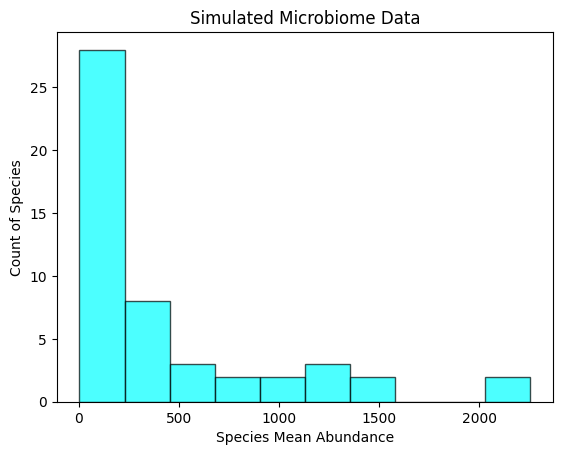

In [46]:
# Example usage
n_samples = 1000
n_species = 50
df = simulate_microbiome_data(num_samples=n_samples, num_species=n_species)
print(df.head(5))
plot_microbiome_data(df)
df0 = df

## Variational Autoencoder

In [23]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.mu = nn.Linear(16, latent_dim)
        self.logvar = nn.Linear(16, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Softmax(dim=1)
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = self.mu(h), self.logvar(h)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

def train_vae(df, latent_dim=10, epochs=100, batch_size=5, lr=0.001):
    data_tensor = torch.tensor(df.values, dtype=torch.float32)
    dataloader = DataLoader(TensorDataset(data_tensor), batch_size=batch_size, shuffle=True)
    
    input_dim = df.shape[1]
    vae = VAE(input_dim, latent_dim)
    optimizer = optim.Adam(vae.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    for epoch in range(epochs):
        for batch in dataloader:
            x = batch[0]
            x_recon, mu, logvar = vae(x)
            loss = loss_fn(x_recon, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    
    return vae

def generate_new_data(vae, num_samples=10, latent_dim=10):
    """
    Generates new microbiome data using the trained VAE model.
    
    Parameters:
    - vae: Trained VAE model
    - num_samples: Number of new samples to generate
    - latent_dim: Dimensionality of the latent space
    
    Returns:
    - DataFrame containing generated microbial abundances
    """
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim)
        generated_data = vae.decoder(z).numpy()
    
    species_names = [f"Species_{i+1}" for i in range(generated_data.shape[1])]
    sample_names = [f"Generated_Sample_{i+1}" for i in range(num_samples)]
    df_generated = pd.DataFrame(generated_data, index=sample_names, columns=species_names)
    
    return df_generated

In [30]:
vae_model = train_vae(df, latent_dim=2, epochs=500, batch_size=5, lr=0.001)

Epoch 0, Loss: 1397937.25
Epoch 50, Loss: 1043967.625
Epoch 100, Loss: 1335250.5
Epoch 150, Loss: 1186216.5
Epoch 200, Loss: 751272.3125
Epoch 250, Loss: 1086564.875
Epoch 300, Loss: 881508.25
Epoch 350, Loss: 1252097.875
Epoch 400, Loss: 865266.0
Epoch 450, Loss: 1344867.875


                    Species_1  Species_2  Species_3  Species_4  Species_5  \
Generated_Sample_1   0.024355   0.025935   0.017166   0.023380   0.015906   
Generated_Sample_2   0.024914   0.019025   0.019172   0.027423   0.020777   
Generated_Sample_3   0.025173   0.020384   0.018688   0.025896   0.019362   
Generated_Sample_4   0.024470   0.025603   0.017287   0.023606   0.016079   
Generated_Sample_5   0.025106   0.022981   0.017638   0.023864   0.018405   

                    Species_6  Species_7  Species_8  Species_9  Species_10  \
Generated_Sample_1   0.023022   0.020168   0.025434   0.019040    0.019072   
Generated_Sample_2   0.019215   0.022767   0.028101   0.020238    0.017321   
Generated_Sample_3   0.020265   0.022682   0.028029   0.019653    0.017451   
Generated_Sample_4   0.022950   0.020471   0.025361   0.018999    0.019064   
Generated_Sample_5   0.020954   0.022161   0.026454   0.019900    0.018107   

                    ...  Species_41  Species_42  Species_43  Species

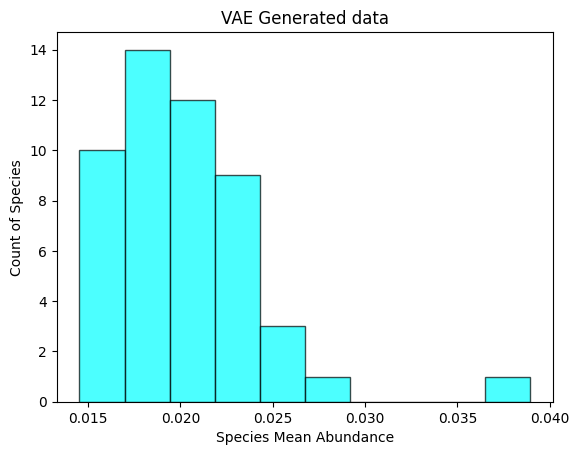

In [47]:
gen_data_v = generate_new_data(vae_model, num_samples=100, latent_dim=2)
print(gen_data_v.head())
plot_microbiome_data(gen_data_v, main='VAE Generated data')

 ## Hyperparameters that can be adjusted

| **Parameter**        | **Recommended Values**                             |
| ---------------------|---------------------------------------------------|
| `latent_dim`        | 2–100 (depends on data complexity)                 |
| `beta` (KL weight)  | 0.1–10 (tune based on regularization needs)       |
| `learning_rate`     | 1e-3 to 1e-4 (use Adam optimizer)                  |
| `batch_size`        | 32–128                                            |
| `loss_function`     | MSE (for continuous data), BCE (for images)        |
| `epochs`           | 50–500 (use early stopping)                        |
| `activation`        | ReLU (hidden layers), Sigmoid/Tanh (output)        |
| `no. of layers` | 2 - 5 |                                      
                                      
- latent_dim: lower number increases generalization and loses detail
- Prevent overfitting with regularization (dropout, early stop...)


In [ ]:
## Autoregressive Model

In [34]:
class AutoregressiveModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(AutoregressiveModel, self).__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

def train_autoregressive(df, epochs=500, batch_size=5, lr=0.001):
    data_tensor = torch.tensor(df.values, dtype=torch.float32).unsqueeze(1)
    dataloader = DataLoader(TensorDataset(data_tensor), batch_size=batch_size, shuffle=True)
    
    input_dim = df.shape[1]
    model = AutoregressiveModel(input_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    for epoch in range(epochs):
        for batch in dataloader:
            x = batch[0]
            output = model(x)
            loss = loss_fn(output, x[:, -1, :])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    
    return model

def generate_autoregressive_data(model, num_samples=10, input_dim=10):
    with torch.no_grad():
        x = torch.randn(num_samples, 1, input_dim)
        generated_data = model(x).numpy()
    species_names = [f"Species_{i+1}" for i in range(input_dim)]
    sample_names = [f"Generated_Sample_{i+1}" for i in range(num_samples)]
    return pd.DataFrame(generated_data, index=sample_names, columns=species_names)


In [35]:
# Example usage
autoregressive_model = train_autoregressive(df, epochs=500, batch_size=5, lr=0.001)

Epoch 0, Loss: 1083477.5
Epoch 50, Loss: 480177.09375
Epoch 100, Loss: 591141.0
Epoch 150, Loss: 388734.90625
Epoch 200, Loss: 427656.25
Epoch 250, Loss: 594287.875
Epoch 300, Loss: 1706936.75
Epoch 350, Loss: 354713.90625
Epoch 400, Loss: 948073.8125
Epoch 450, Loss: 354371.5


                    Species_1   Species_2   Species_3  Species_4  Species_5  \
Generated_Sample_1  28.114182  560.733154  230.868088  79.105659   4.875130   
Generated_Sample_2  -6.994884  -47.885349  -31.247948 -16.619083  -2.026840   
Generated_Sample_3  -7.307526  -24.361185  -37.120411  -9.488108  -0.092130   
Generated_Sample_4  -6.703885   29.502916  -42.333065 -23.020678  -2.569685   
Generated_Sample_5   6.508150  193.001999   66.092064  23.258486   2.095748   

                    Species_6  Species_7   Species_8  Species_9  Species_10  \
Generated_Sample_1   8.097331   1.833484  209.037201  31.489016   93.403824   
Generated_Sample_2  -0.282838  -0.825287  -38.644115 -14.973047  -28.108681   
Generated_Sample_3   0.972610  -0.920822  -33.456867 -11.126685  -14.967125   
Generated_Sample_4   3.808023   0.921240  -25.402046 -12.862597  -17.795403   
Generated_Sample_5   1.073757  -0.365714   62.042229   4.519653   23.242193   

                    ...  Species_41  Species_42  S

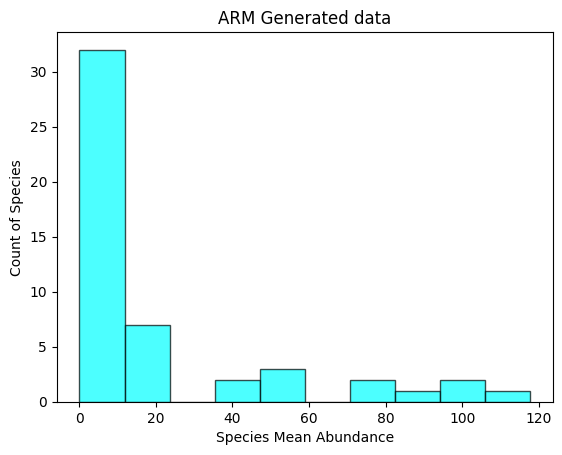

In [48]:
# synthetic data
gen_data_a = generate_autoregressive_data(autoregressive_model, num_samples=100, input_dim=df.shape[1])
print(gen_data_a.head())
plot_microbiome_data(gen_data_a, main='ARM Generated data')

In [49]:
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, timesteps=100):
        super(DiffusionModel, self).__init__()
        self.timesteps = timesteps
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x, t):
        return self.network(x)

def diffusion_training(df, epochs=500, batch_size=5, lr=0.001, timesteps=100):
    data_tensor = torch.tensor(df.values, dtype=torch.float32)
    dataloader = DataLoader(TensorDataset(data_tensor), batch_size=batch_size, shuffle=True)
    input_dim = df.shape[1]
    model = DiffusionModel(input_dim, timesteps)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    for epoch in range(epochs):
        for batch in dataloader:
            x = batch[0]
            t = torch.randint(0, timesteps, (x.shape[0],))
            noise = torch.randn_like(x)
            x_noisy = x + noise
            pred_noise = model(x_noisy, t)
            loss = loss_fn(pred_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    return model

def generate_diffusion_data(model, input_dim, num_samples=10, timesteps=100):
    with torch.no_grad():
        x = torch.randn(num_samples, input_dim)
        for t in reversed(range(timesteps)):
            noise = model(x, torch.tensor([t]*num_samples))
            x = x - noise / timesteps
    species_names = [f"Species_{i+1}" for i in range(input_dim)]
    sample_names = [f"Generated_Sample_{i+1}" for i in range(num_samples)]
    return pd.DataFrame(x.numpy(), index=sample_names, columns=species_names)

In [50]:
# Example usage
diffusion_model = diffusion_training(df, epochs=500, batch_size=5, lr=0.001, timesteps=100)

Epoch 0, Loss: 13.460949897766113
Epoch 50, Loss: 0.9063023924827576
Epoch 100, Loss: 1.106594204902649
Epoch 150, Loss: 0.9257947206497192
Epoch 200, Loss: 1.1935887336730957
Epoch 250, Loss: 1.1143425703048706
Epoch 300, Loss: 1.0731050968170166
Epoch 350, Loss: 0.984753429889679
Epoch 400, Loss: 0.9408075213432312
Epoch 450, Loss: 0.9827710390090942


                    Species_1  Species_2  Species_3  Species_4  Species_5  \
Generated_Sample_1  -1.114395   1.530986   0.929664   1.157463  -1.703205   
Generated_Sample_2   0.694050  -0.740168  -0.725691   0.732841   1.926426   
Generated_Sample_3  -0.020282  -0.208400  -1.836653  -1.544347   0.369074   
Generated_Sample_4  -1.346573  -0.087816  -1.192584   0.380671   0.082057   
Generated_Sample_5  -1.430063  -1.715067  -0.223492   1.141659  -1.237927   

                    Species_6  Species_7  Species_8  Species_9  Species_10  \
Generated_Sample_1   0.296336   1.610418  -0.523646   0.135337   -2.993509   
Generated_Sample_2   0.103108  -0.875129   0.031484  -0.455919   -1.090987   
Generated_Sample_3  -1.193532  -0.615406  -1.462194   0.334075   -1.425091   
Generated_Sample_4  -0.484657   0.459392  -0.532091   0.492622   -1.172452   
Generated_Sample_5   0.412194  -1.374015   0.303843  -1.216776    0.053448   

                    ...  Species_41  Species_42  Species_43  Species

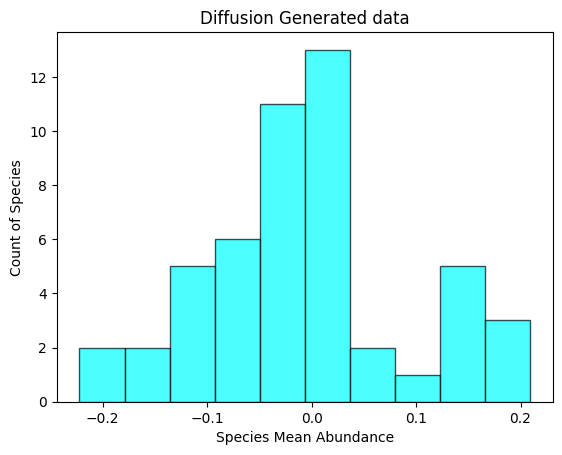

In [51]:
gen_data_d = generate_diffusion_data(diffusion_model, input_dim=df.shape[1], num_samples=100, timesteps=100)
print(gen_data_d.head())
plot_microbiome_data(gen_data_d, main='Diffusion Generated data')

## GAN

In [52]:

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, output_dim), nn.Softmax(dim=1)
        )
    
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 1), nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

def train_gan(df, latent_dim=10, epochs=500, batch_size=5, lr=0.0002):
    data_tensor = torch.tensor(df.values, dtype=torch.float32)
    dataloader = DataLoader(TensorDataset(data_tensor), batch_size=batch_size, shuffle=True)
    
    input_dim = df.shape[1]
    generator = Generator(latent_dim, input_dim)
    discriminator = Discriminator(input_dim)
    
    optimizer_G = optim.Adam(generator.parameters(), lr=lr)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)
    loss_fn = nn.BCELoss()
    
    for epoch in range(epochs):
        for real_data in dataloader:
            real_data = real_data[0]
            batch_size = real_data.size(0)
            
            # Train Discriminator
            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)
            z = torch.randn(batch_size, latent_dim)
            fake_data = generator(z)
            
            real_loss = loss_fn(discriminator(real_data), real_labels)
            fake_loss = loss_fn(discriminator(fake_data.detach()), fake_labels)
            d_loss = (real_loss + fake_loss) / 2
            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()
            
            # Train Generator
            g_loss = loss_fn(discriminator(fake_data), real_labels)
            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")
    
    return generator

def generate_gan_data(generator, num_samples=10, latent_dim=10):
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim)
        generated_data = generator(z).numpy()
    species_names = [f"Species_{i+1}" for i in range(generated_data.shape[1])]
    sample_names = [f"Generated_Sample_{i+1}" for i in range(num_samples)]
    return pd.DataFrame(generated_data, index=sample_names, columns=species_names)


In [53]:
# Example usage
gan_generator = train_gan(df, latent_dim=10, epochs=500, batch_size=5, lr=0.0002)


Epoch 0, D Loss: 0.28558093309402466, G Loss: 0.832844078540802
Epoch 50, D Loss: 2.473152562743053e-06, G Loss: 12.217423439025879
Epoch 100, D Loss: 2.8959826536834044e-08, G Loss: 16.664695739746094
Epoch 150, D Loss: 8.437742171629736e-10, G Loss: 20.200225830078125
Epoch 200, D Loss: 2.0596360728042384e-10, G Loss: 21.61042594909668
Epoch 250, D Loss: 2.091994286135268e-11, G Loss: 23.89740753173828
Epoch 300, D Loss: 1.0871604831652615e-11, G Loss: 24.5518798828125
Epoch 350, D Loss: 2.0950960150784015e-12, G Loss: 26.198413848876953
Epoch 400, D Loss: 8.572740499250553e-13, G Loss: 27.091930389404297
Epoch 450, D Loss: 5.360847399674129e-13, G Loss: 27.56137466430664


                       Species_1     Species_2     Species_3     Species_4  \
Generated_Sample_1  1.325347e-36  1.012385e-33  2.150221e-32  4.482853e-37   
Generated_Sample_2  1.647473e-19  4.966545e-18  1.902681e-17  1.029897e-19   
Generated_Sample_3  5.785678e-24  4.396750e-22  3.143728e-21  3.186233e-24   
Generated_Sample_4  5.996199e-31  1.526426e-28  2.072749e-27  2.090157e-31   
Generated_Sample_5  4.414426e-24  2.879195e-22  1.827554e-21  2.102207e-24   

                       Species_5     Species_6     Species_7     Species_8  \
Generated_Sample_1  2.889276e-35  1.403721e-37  2.004947e-30  1.002292e-28   
Generated_Sample_2  9.324354e-19  5.654015e-20  2.227543e-16  2.201239e-15   
Generated_Sample_3  3.810385e-23  1.279145e-24  6.872433e-20  8.542973e-19   
Generated_Sample_4  6.646489e-30  8.472491e-32  5.926650e-26  2.117758e-24   
Generated_Sample_5  3.097124e-23  1.085344e-24  3.109357e-20  5.741150e-19   

                       Species_9    Species_10  ...    Species

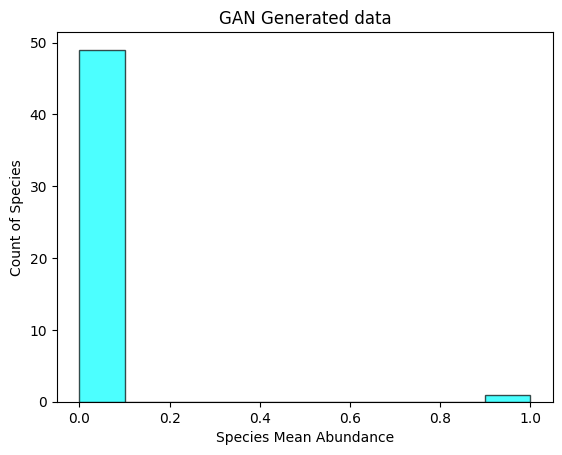

In [55]:
gen_data_g = generate_gan_data(gan_generator, num_samples=100, latent_dim=10)
print(gen_data_g.head())
plot_microbiome_data(gen_data_g, main='GAN Generated data')

## Normalizing Flow Model

In [56]:

# Affine Coupling Layer for RealNVP
class AffineCoupling(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.scale_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()
        )
        self.translate_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, reverse=False):
        s = self.scale_net(x)
        t = self.translate_net(x)
        if not reverse:
            x = x * torch.exp(s) + t
        else:
            x = (x - t) * torch.exp(-s)
        return x, torch.sum(s, dim=1)

# RealNVP Model
class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_flows):
        super().__init__()
        self.flows = nn.ModuleList([AffineCoupling(input_dim, hidden_dim) for _ in range(num_flows)])
        self.prior = torch.distributions.Normal(torch.zeros(input_dim), torch.ones(input_dim))
    
    def forward(self, x):
        log_det_jacobian = torch.zeros(x.shape[0])
        for flow in self.flows:
            x, log_det = flow(x)
            log_det_jacobian += log_det
        log_prob = self.prior.log_prob(x).sum(dim=1) + log_det_jacobian
        return log_prob

    def sample(self, num_samples):
        z = self.prior.sample((num_samples,))
        for flow in reversed(self.flows):
            z, _ = flow(z, reverse=True)
        return z

def train_normalizing_flow(df, latent_dim=10, num_flows=3, epochs=500, batch_size=5, lr=0.0002):
    data_tensor = torch.tensor(df.values, dtype=torch.float32)
    dataloader = DataLoader(TensorDataset(data_tensor), batch_size=batch_size, shuffle=True)
    
    input_dim = df.shape[1]
    model = RealNVP(input_dim, latent_dim, num_flows)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            x = batch[0]
            loss = -model(x).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Loss = {total_loss / len(dataloader):.4f}")
    
    return model

def generate_normalizing_flow_data(model, num_samples=10, input_dim=50):
    generated_data = model.sample(num_samples).detach().numpy()
    species_names = [f"Species_{i+1}" for i in range(input_dim)]
    sample_names = [f"Generated_Sample_{i+1}" for i in range(num_samples)]
    return pd.DataFrame(generated_data, index=sample_names, columns=species_names)


In [57]:
# Usage example
flow_generator = train_normalizing_flow(df, latent_dim=10, num_flows=5, epochs=500, batch_size=5, lr=0.0002)


Epoch 0: Loss = 4671953966.5600
Epoch 50: Loss = 105167833.3000
Epoch 100: Loss = 8080862.5788
Epoch 150: Loss = 1506164.3293
Epoch 200: Loss = 187204.9807
Epoch 250: Loss = 37434.2528
Epoch 300: Loss = 7410.9481
Epoch 350: Loss = 1701.3883
Epoch 400: Loss = 923.0874
Epoch 450: Loss = 1036.2177


                    Species_1  Species_2  Species_3  Species_4  Species_5  \
Generated_Sample_1   9.154528   1.884155 -14.178860   2.256858  -0.537783   
Generated_Sample_2  19.366734  -2.259014   0.404008   0.246630  -0.984947   
Generated_Sample_3  -2.810786  -1.294701  -3.896779   0.493099  12.848325   
Generated_Sample_4  -0.775610   0.629605   0.078121   1.300891  -0.029226   
Generated_Sample_5   2.089824   0.325699 -36.302982   0.396739   4.030089   

                    Species_6  Species_7  Species_8  Species_9  Species_10  \
Generated_Sample_1  -7.388272   0.026525  -8.531729  19.321110    2.608186   
Generated_Sample_2  -2.187403  -1.623959  -2.326509  20.057848   19.210030   
Generated_Sample_3   5.000307  -0.450813   0.449333  -8.229490    0.702543   
Generated_Sample_4  -0.621282   1.021652 -13.830938  -1.376507   -1.393046   
Generated_Sample_5   0.236976   0.503503  -5.983286   0.522516   13.664246   

                    ...  Species_41  Species_42  Species_43  Species

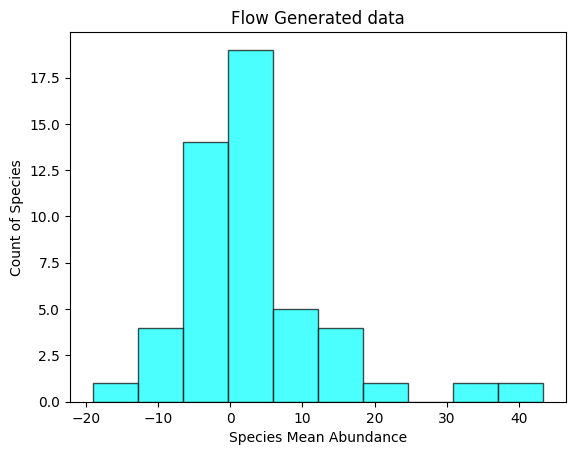

In [58]:
gen_data_f = generate_normalizing_flow_data(flow_generator, num_samples=100, input_dim=df.shape[1])
print(gen_data_f.head())
plot_microbiome_data(gen_data_f, main='Flow Generated data')

### Plot joint results

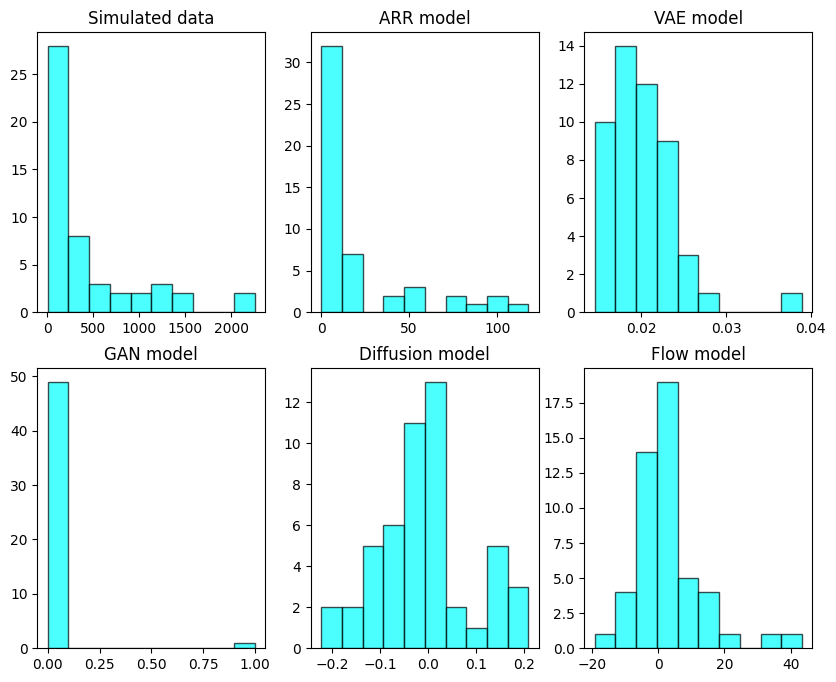

In [65]:
fig, ax = plt.subplots(2, 3, figsize=(10, 8))
ax[0,0].hist(df0.mean(axis=0), color='cyan', edgecolor='black', alpha=0.7)
ax[0,0].set_title('Simulated data')
ax[0,1].hist(gen_data_a.mean(axis=0), color='cyan', edgecolor='black', alpha=0.7)
ax[0,1].set_title('ARR model')
ax[0,2].hist(gen_data_v.mean(axis=0), color='cyan', edgecolor='black', alpha=0.7)
ax[0,2].set_title('VAE model')
ax[1,0].hist(gen_data_g.mean(axis=0), color='cyan', edgecolor='black', alpha=0.7)
ax[1,0].set_title('GAN model')
ax[1,1].hist(gen_data_d.mean(axis=0), color='cyan', edgecolor='black', alpha=0.7)
ax[1,1].set_title('Diffusion model')
ax[1,2].hist(gen_data_f.mean(axis=0), color='cyan', edgecolor='black', alpha=0.7)
ax[1,2].set_title('Flow model')

plt.show()

fig.savefig("genAI.jpg", format="jpg", dpi=300, bbox_inches="tight")